# Urban Ecology Research Trend Analysis

Type: NLP + Time Series + Web Data | Domain: Scientific + environmental | Format: Notebook
- Use PubMed or Semantic Scholar API to extract papers on 'urban ecology'.
- Track number of publications per year.
- Perform keyword frequency and topic modeling.
- Map institutions or authors by location 
    .Use author search and Research Organization Registry (ror.org) to map institutions to locations.

In [ ]:
# For future author search

AUTHOR_URL = 'https://api.semanticscholar.org/graph/v1/author/batch'
AUTHOR_FIELDS = 'affiliations'
AUTHORS_DB_PATH = 'papers.db'
authors_schema = """
    authorId TEXT PRIMARY KEY,
    name TEXT,
    affiliation TEXT
"""

In [70]:
import os
import time
import warnings
import requests
import pandas as pd
import numpy as np
import sqlite3
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

BASE_URL = 'http://api.semanticscholar.org/graph/v1/paper/search/bulk'
FIELDS = 'title,year,authors,url'
PUBLICATION_TYPES = 'Review,JournalArticle,Study,Book,BookSection'
DELAY = 5  # delay between requests to avoid rate limiting
RETRY_DELAY = 5  # seconds before retrying on failure
YEAR_RANGE = '2000-2024'
PAPERS_DB_PATH = 'papers.db'
papers_schema = """
    paperId TEXT PRIMARY KEY,
    title TEXT,
    year INTEGER,
    authors TEXT,
    url TEXT,
    search_keyword TEXT,
    firstAuthorId TEXT
"""

query_list = [
    'urban ecology',
    'urban biodiversity',
    'urban ecosystem',
    'urban green spaces',
    'urban wildlife',
    'urban vegetation',
]

In [39]:
# Run this to clear the .txt progress trackers

for keyword in query_list:
    done_file = f'done_{keyword}.txt'
    token_file = f'token_{keyword}.txt'
    if os.path.exists(done_file):
        os.remove(done_file)
        print(f'✅ Progress trackers for "{keyword}" removed.')
    if os.path.exists(token_file):
        os.remove(token_file)
        print(f'✅ Progress trackers for "{keyword}" removed.')
  
if os.path.exists(PAPERS_DB_PATH):      
    os.remove(PAPERS_DB_PATH)
    print(f'✅ Output file "{PAPERS_DB_PATH}" removed.')

✅ Progress trackers for "urban ecology" removed.
✅ Progress trackers for "urban biodiversity" removed.
✅ Progress trackers for "urban ecosystem" removed.
✅ Progress trackers for "urban green spaces" removed.
✅ Progress trackers for "urban wildlife" removed.
✅ Progress trackers for "urban vegetation" removed.
✅ Output file "papers.db" removed.


In [28]:
# === Helper functions ===
# keeps track of keywords and tokens to allow to keep retrieving papers from 
# where you left off in case of a request/response error
def save_token(keyword, token):
    with open(f'token_{keyword}.txt', 'w') as f:
        f.write(token)

def load_token(keyword):
    filename = f'token_{keyword}.txt'
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            return f.read().strip()
    return None

def mark_done(keyword):
    with open(f'done_{keyword}.txt', 'w') as f:
        f.write('completed')

def is_done(keyword):
    return os.path.exists(f'done_{keyword}.txt')

def delete_token(keyword):
    filename = f'token_{keyword}.txt'
    if os.path.exists(filename):
        os.remove(filename)


In [ ]:
# === Database and Dataframe setup ===

def init_table(db_path, table_name, schema_sql):
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute(f"CREATE TABLE IF NOT EXISTS {table_name} ({schema_sql})")
    conn.commit()
    conn.close()
    
def save_paper_to_db(paper, keyword):
    conn = sqlite3.connect(PAPERS_DB_PATH)
    c = conn.cursor()

    paper_id = paper.get("paperId")
    title = paper.get("title")
    year = paper.get("year")
    url = paper.get("url")
    authors_list = paper.get("authors", [])
    authors = ", ".join([a.get("name") for a in authors_list if a.get("name")])
    first_author_id = authors_list[0].get("authorId") if authors_list else None

    try:
        c.execute("""
            INSERT OR IGNORE INTO papers 
            (paperId, title, year, authors, url, search_keyword, firstAuthorId)
            VALUES (?, ?, ?, ?, ?, ?, ?)
        """, (paper_id, title, year, authors, url, keyword, first_author_id))
        conn.commit()
    except sqlite3.Error as e:
        print(f"❌ DB error for paper {paper_id}: {e}")
    finally:
        conn.close()

In [ ]:
# === Main loop over keywords ===

init_table(PAPERS_DB_PATH, "papers", papers_schema)

for keyword in query_list:
    print(f'\n🔍 Processing keyword: "{keyword}"')

    if is_done(keyword):
        print(f'✅ Keyword "{keyword}" already completed. Skipping.')
        continue

    token = load_token(keyword)
    if token:
        print(f'🔄 Resuming from saved token for "{keyword}": {token}')
    else:
        print(f'⏳ Starting fresh for keyword "{keyword}"')

    retrieved = 0

    while True:
        params = {
            'query': keyword,
            'fields': FIELDS,
            'publicationTypes': PUBLICATION_TYPES,
            'limit': 1000
        }
        if YEAR_RANGE:
            params['year'] = YEAR_RANGE
        if token:
            params['token'] = token

        # Retry logic
        for attempt in range(2):
            try:
                response = requests.get(BASE_URL, params=params, timeout=15)
                response.raise_for_status()
                data = response.json()
                break
            except requests.exceptions.RequestException as e:
                print(f'❌ Request error on attempt {attempt+1} for "{keyword}": {e}')
                if attempt == 0:
                    print(f'⏳ Retrying after {RETRY_DELAY} seconds...')
                    time.sleep(RETRY_DELAY)
                else:
                    print('⚠️ Skipping this batch due to repeated failure.')
                    data = None

        if data is None:
            print(f'⚠️ No data retrieved for keyword "{keyword}", breaking loop.')
            break

        papers = data.get('data', [])
        if not papers:
            print(f'⚠️ No papers returned, assuming end of results for "{keyword}"')
            break

        retrieved += len(papers)
        print(f'📄 Retrieved {retrieved} papers so far for "{keyword}"')

        for paper in papers:
            save_paper_to_db(paper, keyword)

        token = data.get('token')
        if token:
            token = data['token']
            save_token(keyword, token)
            time.sleep(DELAY)
        else:
            print(f'✅ Completed all pages for "{keyword}"')
            delete_token(keyword)
            mark_done(keyword)
            break

print('\n🎉 All keywords processed.')


🔍 Processing keyword: "urban ecology"
⏳ Starting fresh for keyword "urban ecology"
📄 Retrieved 1000 papers so far for "urban ecology"
📄 Retrieved 2000 papers so far for "urban ecology"
📄 Retrieved 3000 papers so far for "urban ecology"
📄 Retrieved 4000 papers so far for "urban ecology"
📄 Retrieved 5000 papers so far for "urban ecology"
📄 Retrieved 5796 papers so far for "urban ecology"
✅ Completed all pages for "urban ecology"

🔍 Processing keyword: "urban biodiversity"
⏳ Starting fresh for keyword "urban biodiversity"
📄 Retrieved 1000 papers so far for "urban biodiversity"
📄 Retrieved 2000 papers so far for "urban biodiversity"
📄 Retrieved 3000 papers so far for "urban biodiversity"
📄 Retrieved 4000 papers so far for "urban biodiversity"
📄 Retrieved 5000 papers so far for "urban biodiversity"
📄 Retrieved 6000 papers so far for "urban biodiversity"
📄 Retrieved 6514 papers so far for "urban biodiversity"
✅ Completed all pages for "urban biodiversity"

🔍 Processing keyword: "urban ecosy

In [6]:
with sqlite3.connect(PAPERS_DB_PATH) as conn:
    df_keywords = pd.read_sql_query("""
    SELECT year, search_keyword, COUNT(*) AS paper_count
    FROM papers
    WHERE year < 2025
    GROUP BY year, search_keyword
    ORDER BY year
""", conn)
    
df_keywords.head()

,year,search_keyword,paper_count
0,2000,urban biodiversity,15
1,2000,urban ecology,47
2,2000,urban ecosystem,34
3,2000,urban green spaces,8
4,2000,urban vegetation,31


In [16]:
fig = px.line(
    df_keywords,
    x='year',
    y='paper_count',
    color='search_keyword',
    title='Research Papers Published by Year',
    markers=True,
)

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Papers',
    legend_title='Keyword',
    font=dict(size=12),
    width=800,
    height=600,
    template='plotly_dark',
    xaxis=dict(showgrid=True,
               dtick=1,
               tickangle=45),
    yaxis=dict(showgrid=True),
)

fig.show()


In [ ]:
df_keyword_pivot = df_keywords.pivot(index='year', columns='search_keyword', values='paper_count')
df_rate = df_keyword_pivot.pct_change()
df_rate.fillna(0, inplace=True)
df_rate.reset_index(inplace=True)

In [59]:
df_melted = df_rate.melt(id_vars="year", var_name="search_keyword", value_name="pct_change")
df_melted['rolling_avg'] = df_melted['pct_change'].rolling(window=3, min_periods=1).mean()
df_melted.head()

fig = px.line(
    df_melted,
    x='year',
    y='rolling_avg',
    color='search_keyword',
    title='Publication Growth Rate by Year',
    markers=True,
)

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Growth Rate',
    legend_title='Keyword',
    font=dict(size=12),
    width=800,
    height=600,
    template='plotly_dark',
    xaxis=dict(showgrid=True,
               dtick=1,
               tickangle=45),
    yaxis=dict(showgrid=True),
)

fig.show()


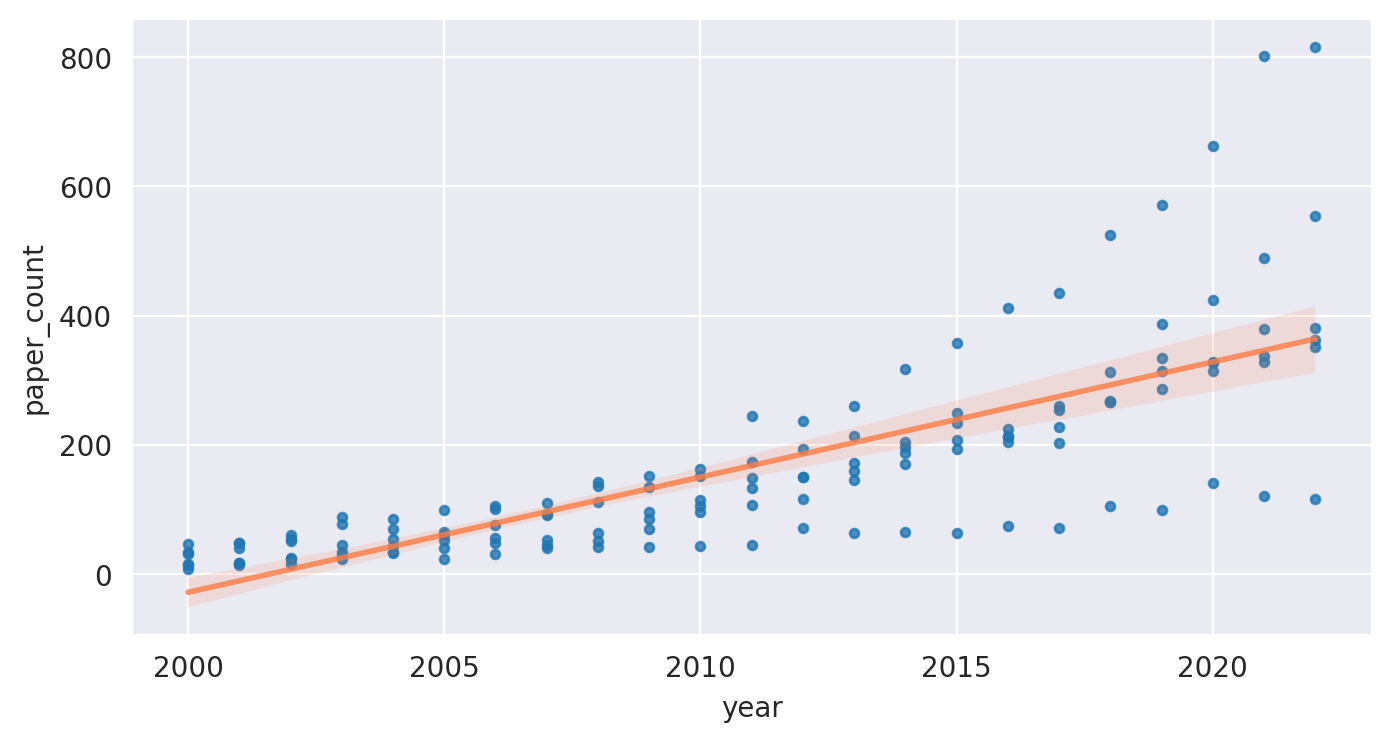

In [72]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style('darkgrid'):
    with np.errstate(divide='ignore', over='ignore', invalid='ignore'):
        ax = sns.regplot(
                data=df_keywords.query('year < 2023'),
                x='year',
                y='paper_count',
                scatter_kws={'s': 10},
                line_kws={
                    'linewidth': 2,
                    'alpha': 0.8,
                    'color': '#ff7c43'
                    },
            )
    
plt.show()
